In [362]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import cv2
import imghdr

## Input Data

In [363]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [364]:
image_classes = [x for x in os.listdir(data_dir) if x[0] != '.'] # subdirectory of classes, rm hidden files '.[...]'

# Remove images with different extensions
for image_class in image_classes:
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            img_ext = imghdr.what(image_path)
            if img_ext not in image_exts:
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except:
            print(f"Some other issue with image {image_path}")

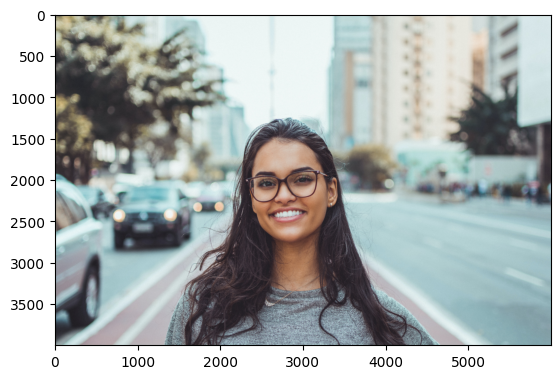

In [36]:
# Display image
img = cv2.imread(os.path.join(data_dir, 'faces', 'pexels-photo-1239291.jpeg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load Data

In [38]:
tf.data.Dataset??

In [48]:
tf.keras.utils.image_dataset_from_directory??

In [127]:
# tf.keras pipeline processes data, stores in a generator
### resizes images to (256, 256)
### labels data based on directory classes
### batches images to set of 32 and shuffles it
data = tf.keras.utils.image_dataset_from_directory(data_dir, seed=1)

Found 212 files belonging to 2 classes.


In [104]:
data_iterator = data.as_numpy_iterator() # this is a generator

In [108]:
batch = data_iterator.next()

In [109]:
print(batch[0].shape, batch[1].shape) # batch of resized numpy arrays and its y labels
print(batch[1])

(32, 256, 256, 3) (32,)
[1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1]


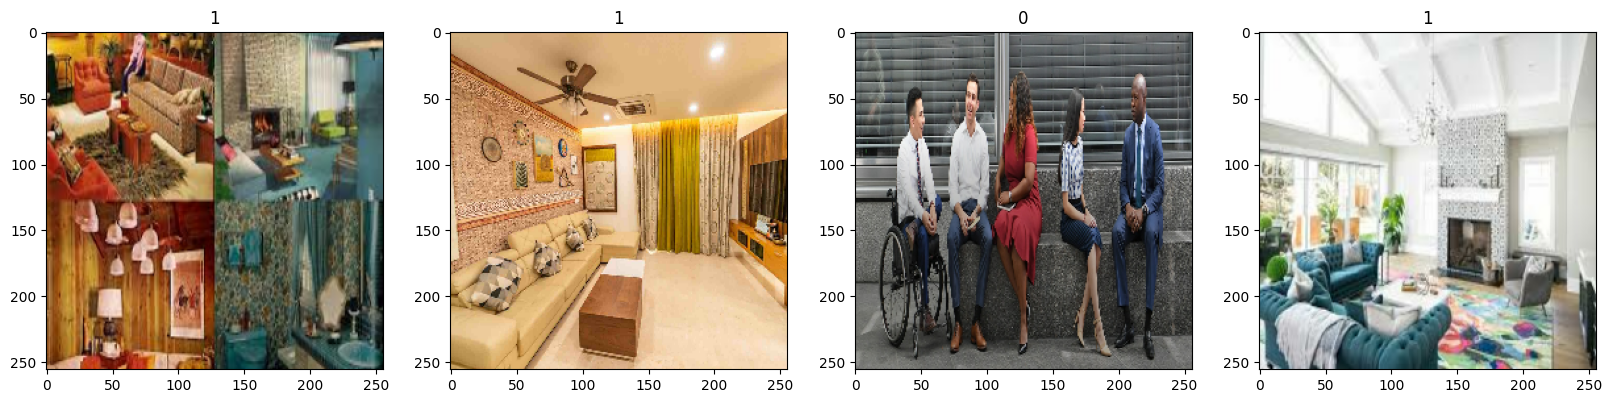

In [110]:
# Class 0 : Faces   Class 1 : Nonfaces
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocess Data

In [128]:
# Scale data by dividing by 255
data = data.map(lambda x, y: (x / 255, y))

In [129]:
scaled_iterator = data.as_numpy_iterator() # new scaled generator

In [134]:
batch = scaled_iterator.next()

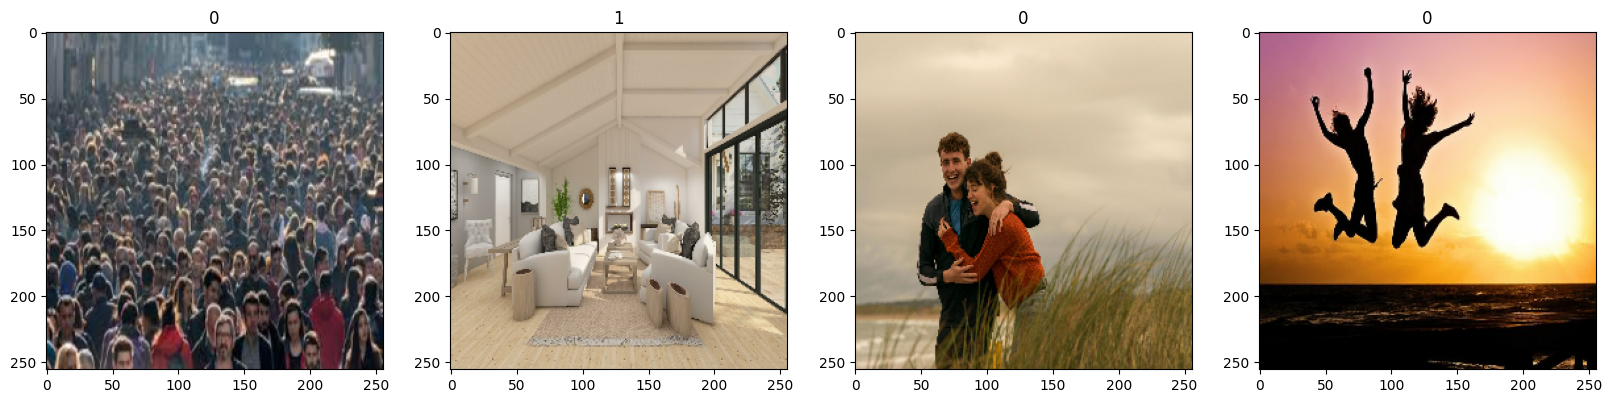

In [135]:
# Class 0 : Faces   Class 1 : Nonfaces
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [136]:
len(data) # of batches

7

In [139]:
# Manually split batches
train_size = 5
val_size = 1
test_size = 1

In [140]:
train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size).take(test_size)

In [159]:
len(train)

5

## Build and Train Model

In [154]:
model = Sequential([
    Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    
    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(16, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [155]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 16)      

In [160]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [175]:
# Set up logs to log model metrics to file 'logs'
log_dir = 'logs'

In [176]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [178]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 13s 1s/step - loss: 0.8430 - accuracy: 0.4375 - val_loss: 0.6836 - val_accuracy: 0.5312
Epoch 2/20
5/5 [==============================] - 10s 1s/step - loss: 0.6853 - accuracy: 0.5437 - val_loss: 0.6636 - val_accuracy: 0.8750
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.6469 - accuracy: 0.6875 - val_loss: 0.6026 - val_accuracy: 0.7500
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 0.5728 - accuracy: 0.7750 - val_loss: 0.4982 - val_accuracy: 0.7188
Epoch 5/20
5/5 [==============================] - 12s 2s/step - loss: 0.4976 - accuracy: 0.7375 - val_loss: 0.4704 - val_accuracy: 0.6875
Epoch 6/20
5/5 [==============================] - 11s 2s/step - loss: 0.3915 - accuracy: 0.8687 - val_loss: 0.2674 - val_accuracy: 0.9375
Epoch 7/20
5/5 [==============================] - 11s 2s/step - loss: 0.2625 - accuracy: 0.9187 - val_loss: 0.1956 - val_accuracy: 0.9375
Epoch 8/20
5/5 [==================

In [180]:
hist.history

{'loss': [0.8430217504501343,
  0.6853153109550476,
  0.6468594074249268,
  0.572812557220459,
  0.49762120842933655,
  0.39146891236305237,
  0.2624780535697937,
  0.20863905549049377,
  0.17248867452144623,
  0.116440549492836,
  0.07941371947526932,
  0.06450588256120682,
  0.04132949560880661,
  0.025708649307489395,
  0.014018123038113117,
  0.00847548060119152,
  0.004323479253798723,
  0.003388453973457217,
  0.003948704805225134,
  0.0020706914365291595],
 'accuracy': [0.4375,
  0.543749988079071,
  0.6875,
  0.7749999761581421,
  0.737500011920929,
  0.8687499761581421,
  0.918749988079071,
  0.9437500238418579,
  0.9437500238418579,
  0.956250011920929,
  0.987500011920929,
  0.9750000238418579,
  0.9937499761581421,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.6836153268814087,
  0.663625955581665,
  0.6026455760002136,
  0.4981617331504822,
  0.4703817367553711,
  0.26741480827331543,
  0.19563674926757812,
  0.2904995381832123,
  0.13940776884555817,
 

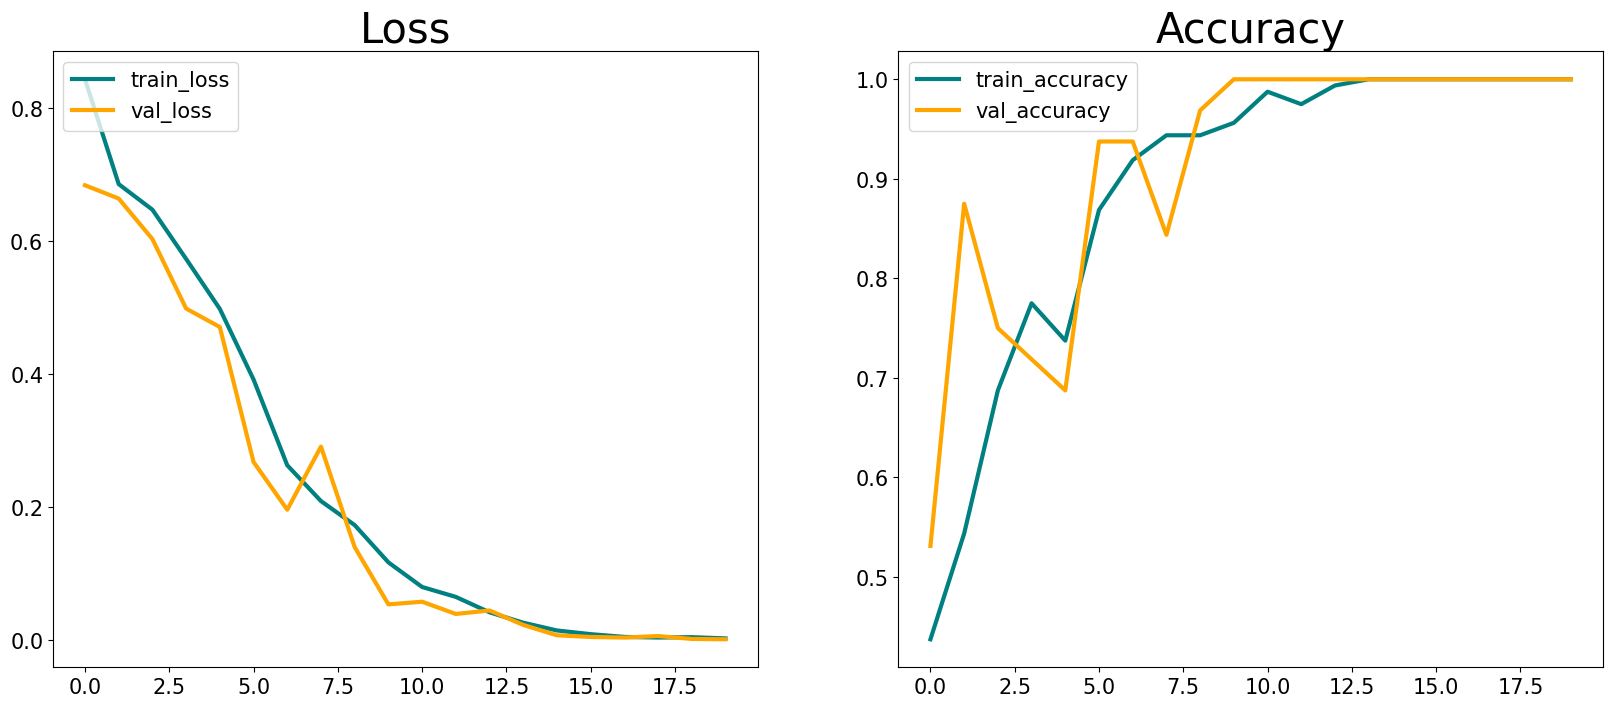

In [274]:
# Plot loss and accuracy from the stored hist logs
fig, ax = plt.subplots(ncols=2, figsize=(20,8))
ax[0].plot(hist.history['loss'], color='teal', linewidth=3, label='train_loss')
ax[0].plot(hist.history['val_loss'], color='orange', linewidth=3, label='val_loss')
ax[0].set_title('Loss', fontsize=30)
ax[0].legend(loc='upper left', fontsize=15)
ax[1].plot(hist.history['accuracy'], color='teal', linewidth=3, label='train_accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', linewidth=3, label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=30)
ax[1].legend(loc='upper left', fontsize=15)

## Evaluate and Test Model

In [298]:
# Get precision, recall, accuracy, F1 metrics
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [299]:
# Get metrics for each test batch
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 155ms/step


In [300]:
pre = pre.result().numpy(); rec = rec.result().numpy(); acc = acc.result().numpy()
f1 = 2 * pre * rec / (pre + rec)
print(f"Precision: {pre}  Recall: {rec}  Accuracy {acc}")
print(f"F1 Score: {f1}")

Precision: 1.0  Recall: 1.0  Accuracy 1.0
F1 Score: 1.0


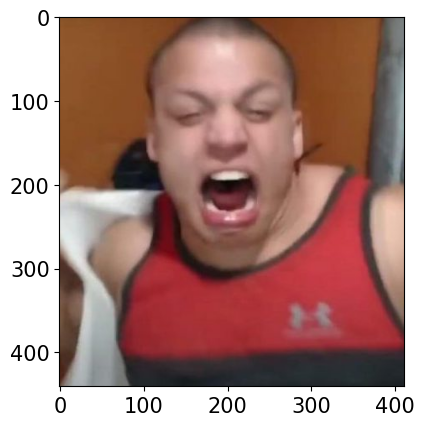

In [416]:
# Test single image, pass to model
img = cv2.imread('test9.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

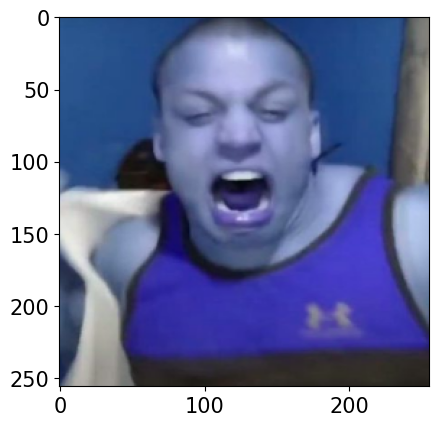

In [418]:
resize = tf.image.resize(img, (256, 256)) # resize image
plt.imshow(resize.numpy().astype(int))

In [419]:
X_img = resize / 255 # Scale image for new inputs before feeding into model
# Model expects shape=(batch, 256, 256, 3)
X_img = np.expand_dims(X_img, 0) # Add 1 dimension for batch # -> shape=(1, 256, 256, 3)

In [420]:
yhat = model.predict(X_img)

1/1 [==============================] - 0s 157ms/step


In [421]:
print(yhat[0,0])
if yhat > 0.5:
    print("Predicted class: Not Face")
else:
    print("Predicted class: Face")

0.0001082998
Predicted class: Face


In [422]:
model.save('models/facedetectmodel.h5')

In [423]:
model = tf.keras.models.load_model('models/facedetectmodel.h5') # load model